In [1]:
import os
import sys
import matplotlib.pyplot as plt
import scipy.io
#from mat4py import loadmat
import numpy as np
import xarray as xr
import xugrid as xu
import contextily as ctx

# import sfincs_read_and_process_output as sf_py

Load data for SLR = 0, WL = 1.16

In [2]:
dir_base = os.path.join(r"p:\11207365-eoatsee\Majuro\models\SFINCS")

# WL_by = [1.13,1.23,1.29]
# WL_eo = [0.86,1.03,1.16]
WL = 1.29
SLR=0.5

run_dir = os.path.join(dir_base, r'03_modelruns\v2_full\domain_0000_1_USGS\slr_{}_wl_{}'.format(SLR, WL))
nc_file = os.path.join(run_dir,'sfincs_map.nc')
output_dir =  os.path.join(dir_base, r'04_postprocessing\v2_full\domain_0000_1_USGS\slr_{}_wl_{}'.format(SLR, WL))

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok= True)

xu_nc = xu.open_dataset(nc_file , decode_times=False)

modig = {"msk": xu_nc["msk"],
"zb": xu_nc["zb"],
"zs": xu_nc["zs"],
"zsm": xu_nc["zsm"],
"zsmax": xu_nc["zsmax"],
"zsm0": xu_nc["zsm"],
"hm0ig": xu_nc["hm0ig"][-1,:],
"hm0": xu_nc["hm0"][-1,:],
}
xu_nc.close()


In [3]:
modig['msk']

<xarray.DataArray 'msk' (nmesh2d_face: 186925)>
[186925 values with dtype=float64]
Coordinates:
  * nmesh2d_face  (nmesh2d_face) int64 0 1 2 3 4 ... 186921 186922 186923 186924
Attributes:
    units:          -
    standard_name:  mask
    long_name:      msk_active_cells
    description:    inactive=0, active=1, normal_boundary=2, outflow_boundary...

### Overview plot

C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\27961317.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([x/1e3 for x in ax[0].get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\27961317.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y/1e3 for y in ax[0].get_yticks()])  # divide every tick value by 1000


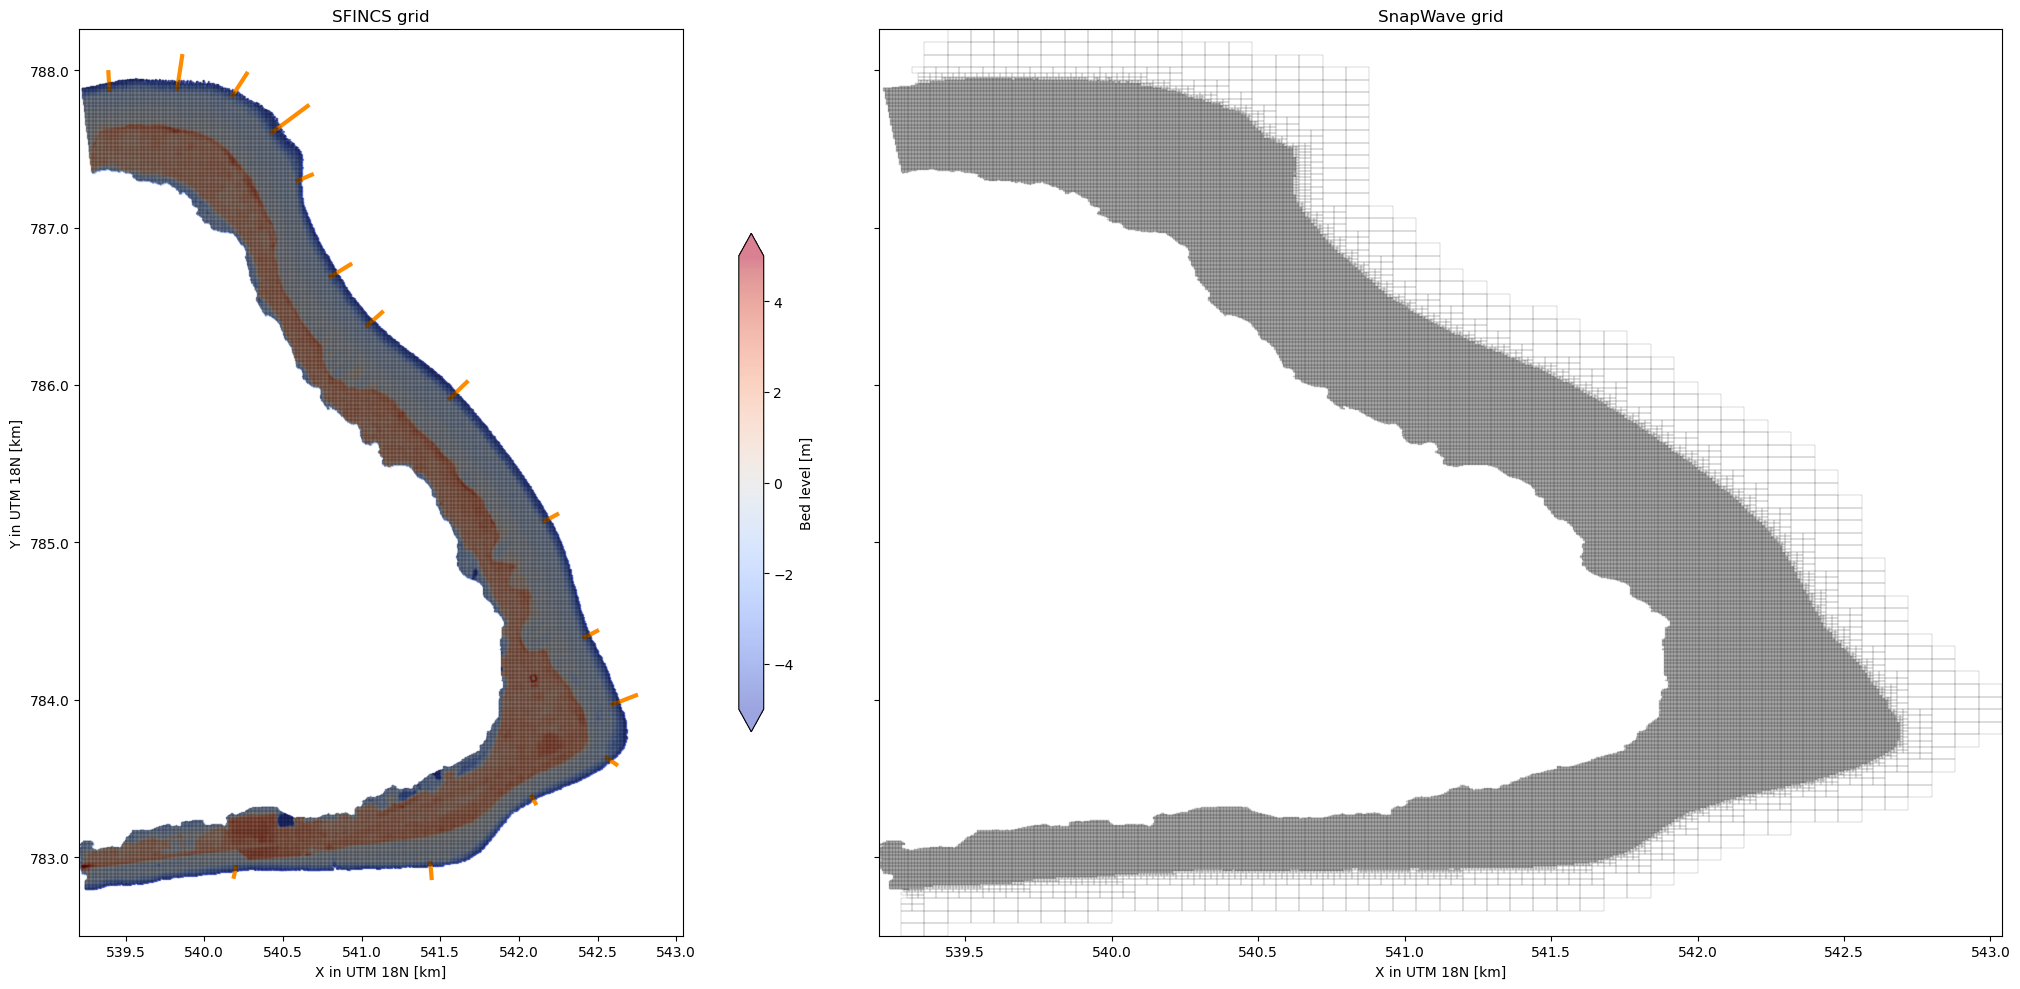

In [4]:
#Plot XBeach transects on sfincs grid

coord_ns = np.loadtxt(os.path.join(run_dir, 'sfincs.bnd'))
coord_os = np.loadtxt(os.path.join(run_dir, 'snapwave.bnd'))

#Plot Snapwave grid

fig, ax = plt.subplots(figsize=(22.6,10), ncols=2, nrows=1, sharex=True, sharey=True)

for i in range(len(coord_ns)):
    ax[0].plot([coord_ns[i,0], coord_os[i,0]], [coord_ns[i, 1], coord_os[i, 1]], color = "darkorange", linewidth = 3)

modig['zb'].ugrid.plot(ax=ax[0], vmin=-5, vmax=5.0,cmap='coolwarm', alpha=0.5, add_labels=False, cbar_kwargs={'label':'Bed level [m]','shrink':0.55,'alpha':0.5})
modig['msk'][(modig['msk']>0)].ugrid.plot.line(ax=ax[0],color="black", linewidth=0.1)
modig['msk'].ugrid.plot.line(ax=ax[1],color="black", linewidth=0.1)

ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('SFINCS grid')

ax[0].set_xticklabels([x/1e3 for x in ax[0].get_xticks()])  # divide every tick value by 1000
ax[0].set_yticklabels([y/1e3 for y in ax[0].get_yticks()])  # divide every tick value by 1000

ax[0].set_xlabel('X in UTM 18N [km]')
ax[0].set_ylabel('Y in UTM 18N [km]')

ax[1].set_title('SnapWave grid')
ax[1].set_xlabel('X in UTM 18N [km]')

fig.tight_layout()

fig.savefig(os.path.join(output_dir, 'overview_grid.jpg'),dpi=500)

### Plotting mask


C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\1243577753.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\1243577753.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000


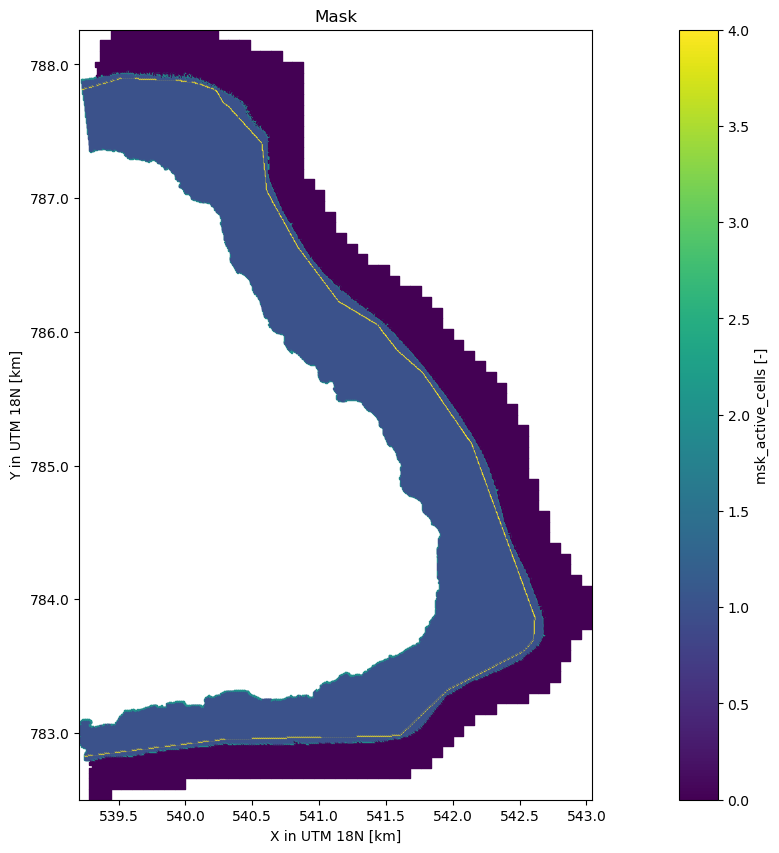

In [5]:
# plot msk - SFINCS
fig, ax = plt.subplots(figsize=(22.6,10), ncols=1, nrows=1, sharex=True, sharey=True)

modig['msk'].ugrid.plot()

ax.set_aspect('equal', adjustable='box')

ax.set_title('Mask')

ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('X in UTM 18N [km]')
ax.set_ylabel('Y in UTM 18N [km]')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

fig.savefig(os.path.join(output_dir, 'sfincs_mask') ,dpi=500)

Text(0.5, 1.0, 'Water level end')

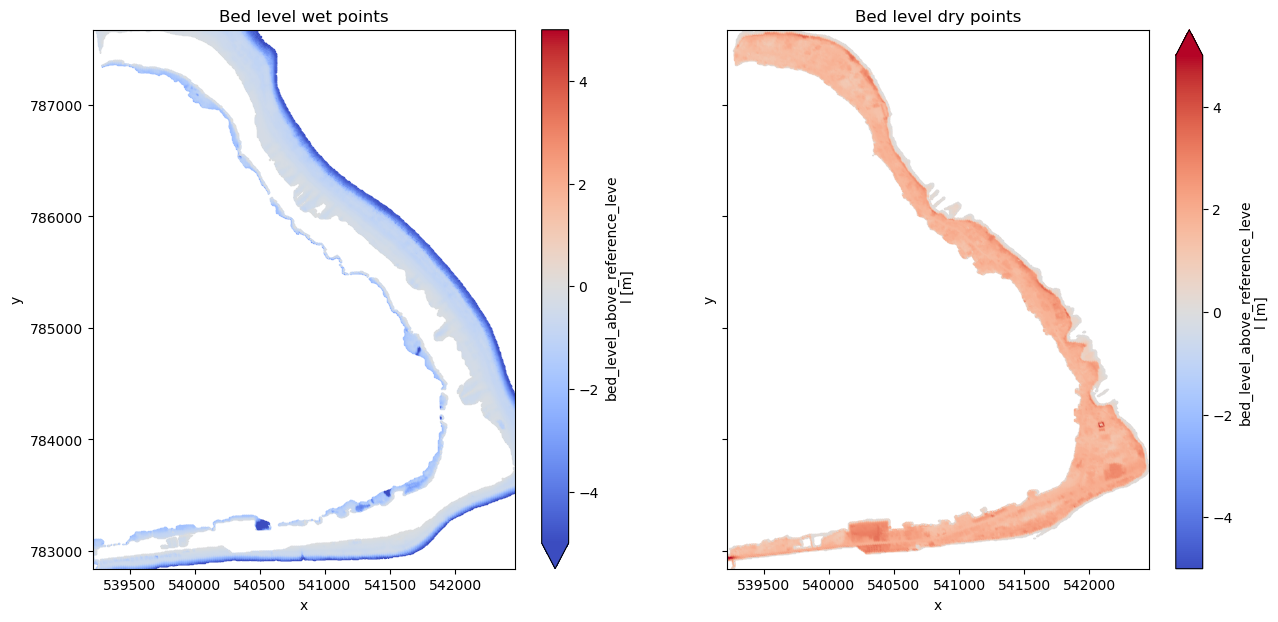

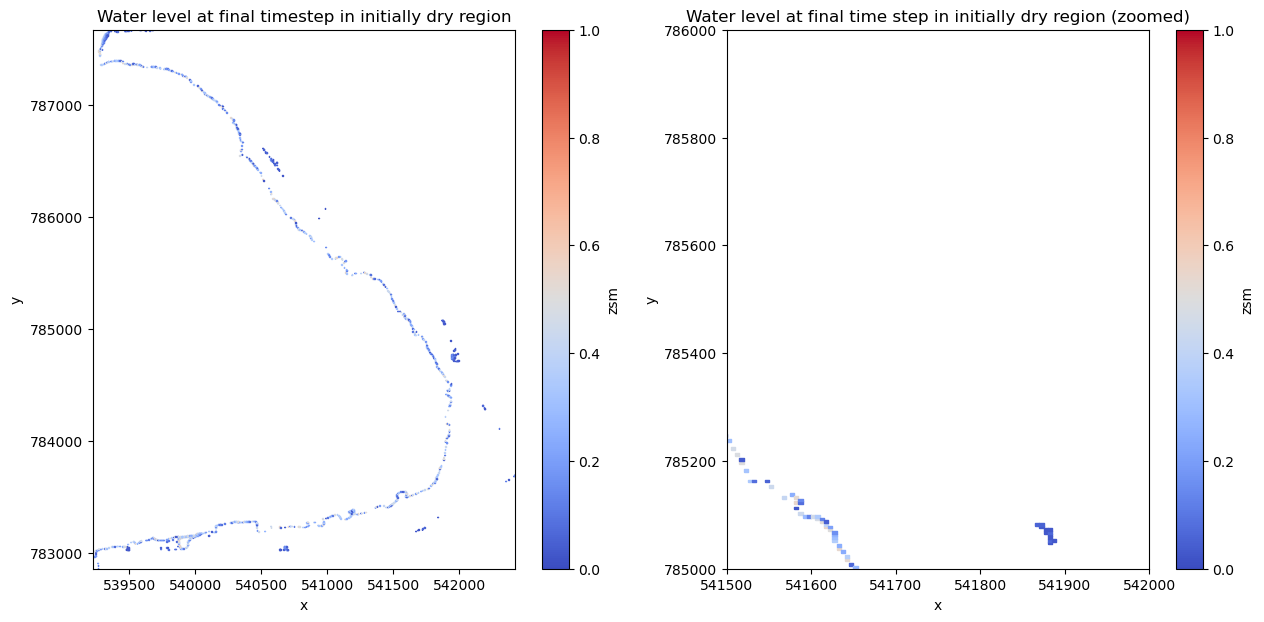

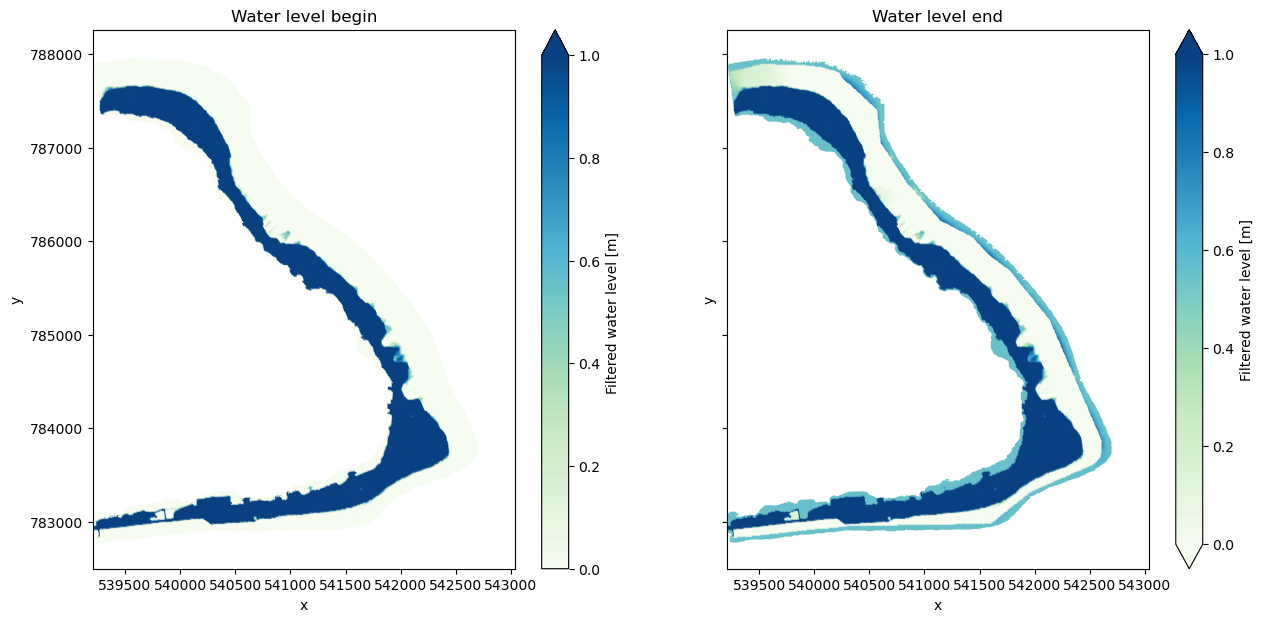

In [6]:
bed_level = modig['zb']
water_level = modig['zs']
filtered_water_level = modig['zsm']

difference_initially = filtered_water_level[0] - bed_level
dry_idx = difference_initially < 0.001

wet_points = bed_level[difference_initially > 0.001]
dry_points = bed_level[difference_initially < 0.001]

water_level_end = filtered_water_level[-1][dry_idx] - filtered_water_level[0][dry_idx]

#water_level_reference = water_level - bed_level

# Initially dry and wet points

fig, ax = plt.subplots(figsize=(15,7), ncols=2, nrows=1, sharex=True, sharey=True)
wet_points.ugrid.plot(ax = ax[0],vmin=-5, vmax=5.0,cmap='coolwarm')
dry_points.ugrid.plot(ax = ax[1],vmin=-5, vmax=5.0,cmap='coolwarm')
ax[0].set_title('Bed level wet points')
ax[1].set_title('Bed level dry points')

#Plot filtered water level at initially dry points

fig, ax = plt.subplots(figsize=(15,7), ncols=2, nrows=1)
#water_level[-1][dry_idx].ugrid.plot(ax = ax[0]) #,vmin=-5, vmax=0,cmap='coolwarm')
water_level_end = water_level_end[water_level_end > 0.02]
water_level_end.ugrid.plot(ax = ax[0],vmin=0, vmax=1,cmap='coolwarm')
water_level_end.ugrid.plot(ax = ax[1], vmin=0, vmax=1,cmap='coolwarm')

ax[1].set_xlim([541500, 542000])
ax[1].set_ylim([785000, 786000])
ax[0].set_title('Water level at final timestep in initially dry region')
ax[1].set_title('Water level at final time step in initially dry region (zoomed)')


# # plot zb - SFINCS

# fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1, sharex=True, sharey=True)
# bed_level.ugrid.plot(ax = ax)
# ax.set_title('Reference bed level')

# plot zs - intial timestep

fig, ax = plt.subplots(figsize=(15,7), ncols=2, nrows=1, sharex=True, sharey=True)

water_level_reference = water_level[0] - bed_level

filtered_water_level[0].ugrid.plot(ax = ax[0], vmin=0, vmax=1,cmap='GnBu')
filtered_water_level[-1].ugrid.plot(ax = ax[1], vmin=0, vmax=1,cmap='GnBu')
ax[0].set_title('Water level begin')
ax[1].set_title('Water level end')



### Maximum waterlevel

Text(0.5, 1.0, 'Maximum water depth at initially dry areas larger than 5 cm')

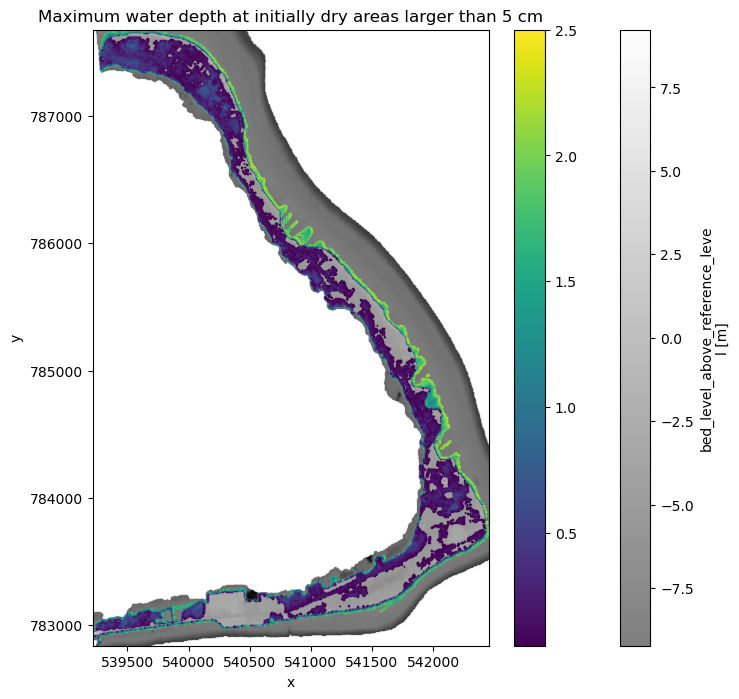

In [20]:
bed_level = modig['zb']
# water_level = modig['zs']
filtered_water_level = modig['zsm']

# water_level_max = modig['zsm'].max(axis = 0)
water_level_max = modig["zsmax"].max(dim="timemax")    
water_level_max_ref =  water_level_max - bed_level

difference_initially = filtered_water_level[0] - bed_level

dry_idx_SLR = difference_initially < 0.001 - SLR
dry_idx = difference_initially < 0.001 

# wet_points = bed_level[difference_initially > 0.001]
# dry_points = bed_level[difference_initially < 0.001]

# Plot max waterlevel

fig, ax = plt.subplots(1,1, figsize = (8,8))
bed_level.ugrid.plot(ax=ax, alpha  = 0.5, cmap='gray')
water_level_max_ref = water_level_max_ref[dry_idx] # Initially dry
water_level_max_ref = water_level_max_ref[water_level_max_ref > 0.05] # Larger tahn 0.05 m
water_level_max_ref.ugrid.plot(ax = ax, vmin = 0.05, vmax=  2.5)
ax.set_title("Maximum water depth at initially dry areas larger than 5 cm")
#ctx.add_basemap(ax, crs= "EPSG:32659", source=ctx.providers.CartoDB.Positron)

# fig, ax = plt.subplots(figsize=(20,20), ncols=3, nrows=2)
# ax_flat = ax.flat

# #Plot filtered water level at initially dry points over time

# t_array = [0,1,2,3,4]

# for idx, t in enumerate(t_array):
#     water_level_diff = filtered_water_level[t] - filtered_water_level[0]
#     water_level_diff[water_level_diff < 0.001] = None
#     water_level_diff.ugrid.plot(ax = ax_flat[idx], vmin =0, vmax = 0.6)
#     #print(water_level_diff[~np.isnan(water_level_diff)])
#     ax_flat[idx].set_title(f"t = {t}")
#     # ax_flat[t].set_xlim([541500, 542000])
#     # ax_flat[t].set_ylim([785000, 786000])



### Compare scenarios


C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3773872903.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3773872903.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3773872903.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3773872903.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000


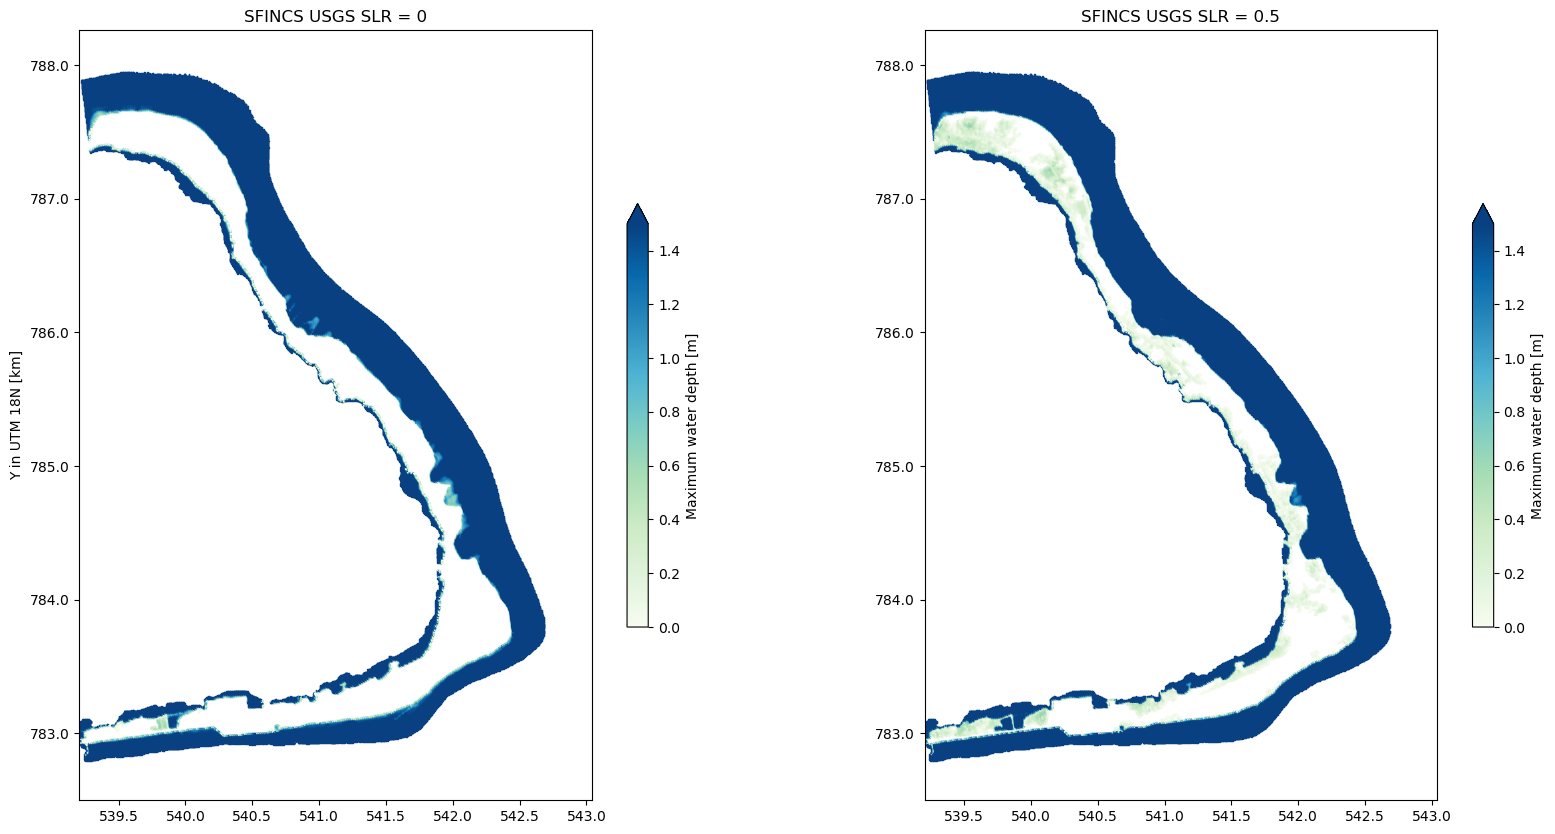

In [8]:
ncname = {}
nc_folder = {}

WL = 1.16
SLRs = [0,0.5]#0.5,1.0]#[0, 0.25, 0.5, 1.0]
bathy = "1_usgs" 

#Droge punten alleen

for id, SLR in enumerate(SLRs):
    ncname[id] = f'SFINCS USGS SLR = {SLR}'
    nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_{}\slr_{}_wl_{}'.format(bathy, SLR, WL)


fig, axes = plt.subplots(1, len(nc_folder), figsize=(20,10), sharex=False, gridspec_kw={'hspace': 0.35})
axes_flat = axes.flat

for id in range(len(nc_folder)):

# for id, value in enumerate(nc_folder):
    nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')

    xu_nc = xu.open_dataset(nc_file, decode_times=False)

    zb = xu_nc["zb"]
    zsmax = xu_nc["zsmax"].max(dim="timemax")    

    xu_nc.close()
    
    # Actual plot        
    hmax_simple = zsmax - zb
    hmax_simple[hmax_simple <= 0.001] = None
    # hmax_simple = (hmax_simple>=0.2) & (zb > 0)
    
    ax = axes_flat[id]
    hmax_simple.ugrid.plot(ax=ax,cmap='GnBu', vmin= 0, vmax = 1.5, add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55, 'alpha':0.5})
    # hmax_simple.ugrid.plot(ax=ax)#ax=ax,cmap='GnBu', vmin= 0, vmax = 1.5, add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55, 'alpha':0.5})

    ax.set_title(ncname[id])
    if id >= 2:
        ax.set_xlabel('X in UTM 18N [km]')
    if id % 2 == 0: #even number       
        ax.set_ylabel('Y in UTM 18N [km]')
    # else:
        # ax.set_xlabel('X in UTM 18N [km]')

    ax.set_aspect('equal', adjustable='box')

    ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
    ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
    
    # ax.set_alpha(0.5)


# fig.tight_layout()

# fig.savefig('figure_detail_flooding_comparison',dpi=500)
  
    


### Compare bathymetry data

C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2017886446.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2017886446.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2017886446.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2017886446.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2017886446.py:82: 

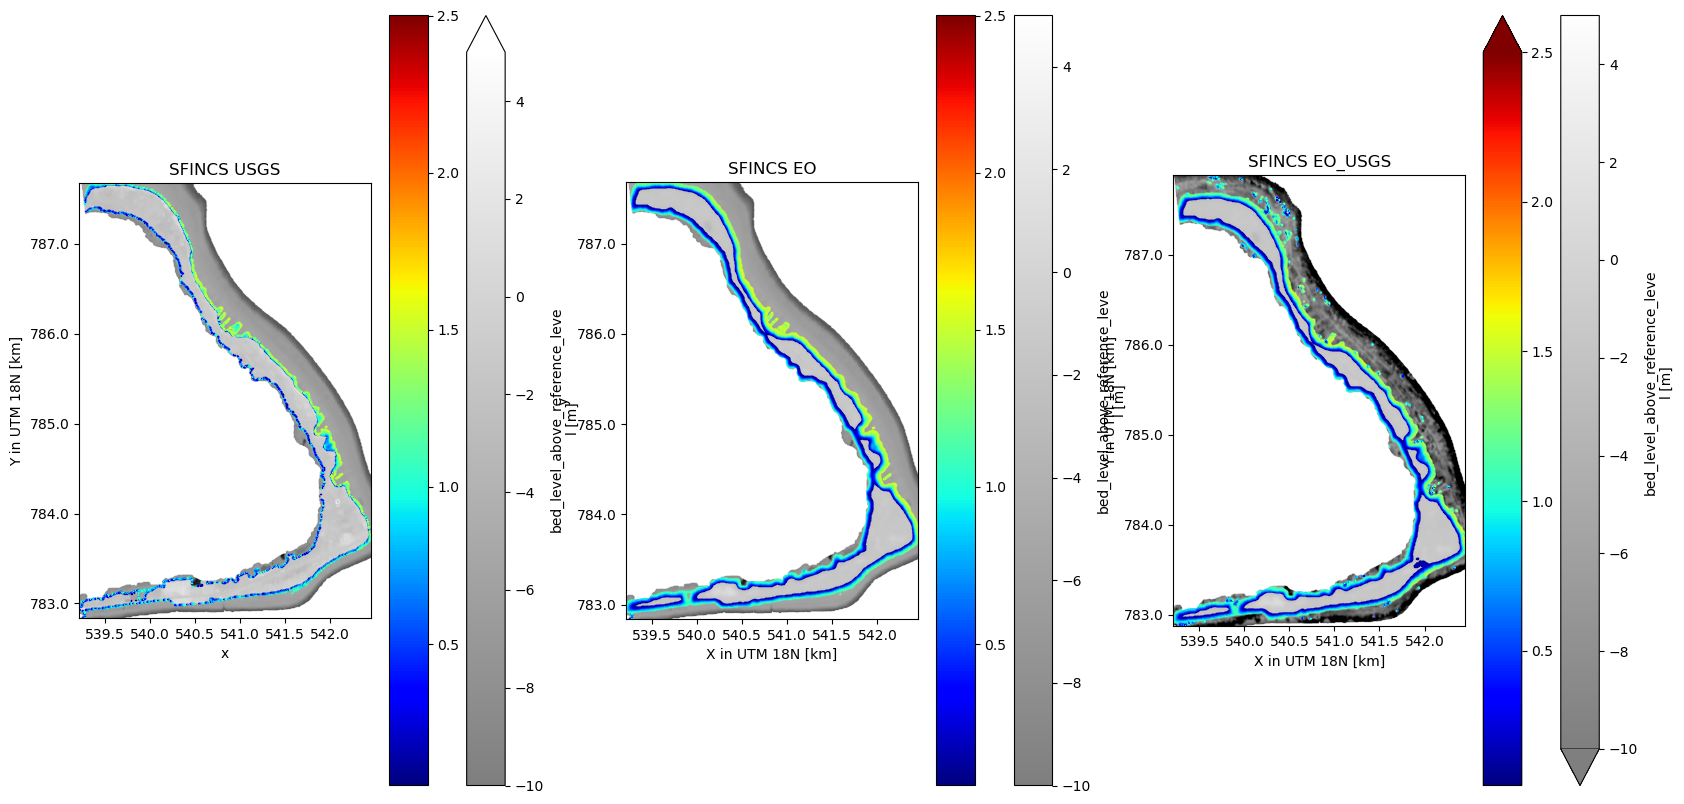

In [5]:
ncname = {}
nc_folder = {}

WL = 1.16
SLR = 0

id = 0
ncname[id] = 'SFINCS USGS'
nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_1_usgs\slr_{}_wl_{}'.format(SLR, WL)

nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')
xu_nc = xu.open_dataset(nc_file, decode_times=False)
bed_level = xu_nc['zb']
filtered_water_level = xu_nc['zsm']

water_level_max = xu_nc['zsm'].max(axis = 0)
water_level_max_ref =  water_level_max - bed_level
difference_initially = filtered_water_level[0] - bed_level
dry_idx_SLR = difference_initially < 0.001 - SLR
dry_idx = difference_initially < 0.001 

# Plot max waterlevel
# fig, ax = plt.subplots(1,1, figsize = (8,8))
# bed_level.ugrid.plot(ax=ax, alpha  = 0.5, cmap='gray')
# water_level_max_ref = water_level_max_ref[dry_idx] # Initially dry
# water_level_max_ref = water_level_max_ref[water_level_max_ref > 0.05] # Larger tahn 0.05 m
# water_level_max_ref.ugrid.plot(ax = ax, vmin = 0.05, vmax=  2.5)
# ax.set_title("Maximum water depth at initially dry areas larger than 5 cm")

id += 1
ncname[id] = 'SFINCS EO'
nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_2_EO\slr_{}_wl_{}'.format(SLR, WL)
id += 1
ncname[id] = 'SFINCS EO_USGS'
nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_3_EO_usgs\slr_{}_wl_{}'.format(SLR, WL)


fig, axes = plt.subplots(1, len(nc_folder), figsize=(20,10), sharex=False, gridspec_kw={'hspace': 0.35})
axes_flat = axes.flat

for id in range(len(nc_folder)):

# for id, value in enumerate(nc_folder):
    nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')

    xu_nc = xu.open_dataset(nc_file, decode_times=False)

    # zb = xu_nc["zb"]
    # zsmax = xu_nc["zsmax"].max(dim="timemax")    
    bed_level = xu_nc['zb']
    filtered_water_level = xu_nc['zsm']
    water_level_max = xu_nc['zsm'].max(axis = 0)
    water_level_max_ref =  water_level_max - bed_level
    difference_initially = filtered_water_level[0] - bed_level #should remove
    dry_idx_SLR = difference_initially < 0.001 - SLR #should remove
    dry_idx = difference_initially < 0.001 #should remove
    
    xu_nc.close()
    
    # Actual plot        
    #hmax_simple = zsmax - zb
    hmax_simple = water_level_max - bed_level
    hmax_simple[hmax_simple <= 0.001] = None
    
    ax = axes_flat[id]
    bed_level.ugrid.plot(ax=ax, alpha  = 0.5, cmap='gray',vmin = -10, vmax=  5)
    water_level_max_ref = water_level_max_ref[dry_idx] # Initially dry
    water_level_max_ref = water_level_max_ref[water_level_max_ref > 0.1] # Larger tahn 0.05 m
    water_level_max_ref.ugrid.plot(ax = ax, vmin = 0.05, vmax=  2.5, cmap = 'jet')
    # hmax_simple.ugrid.plot(ax=ax,cmap='GnBu', vmin = 0, vmax = 3, add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55, 'alpha':0.5})
    
    ax.set_title(ncname[id])
    if id >= 1:
        ax.set_xlabel('X in UTM 18N [km]')
    if id % 2 == 0: #even number       
        ax.set_ylabel('Y in UTM 18N [km]')
    # else:
        # ax.set_xlabel('X in UTM 18N [km]')

    ax.set_aspect('equal', adjustable='box')

    ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
    ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
    
    # ax.set_alpha(0.5)


fig.tight_layout()

fig.savefig('figure_detail_flooding_comparison_WL116_SLR0',dpi=500)
  
    


# Compare WL buoy vs EO

C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3485225663.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3485225663.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3485225663.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3485225663.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_16840\3485225663.py

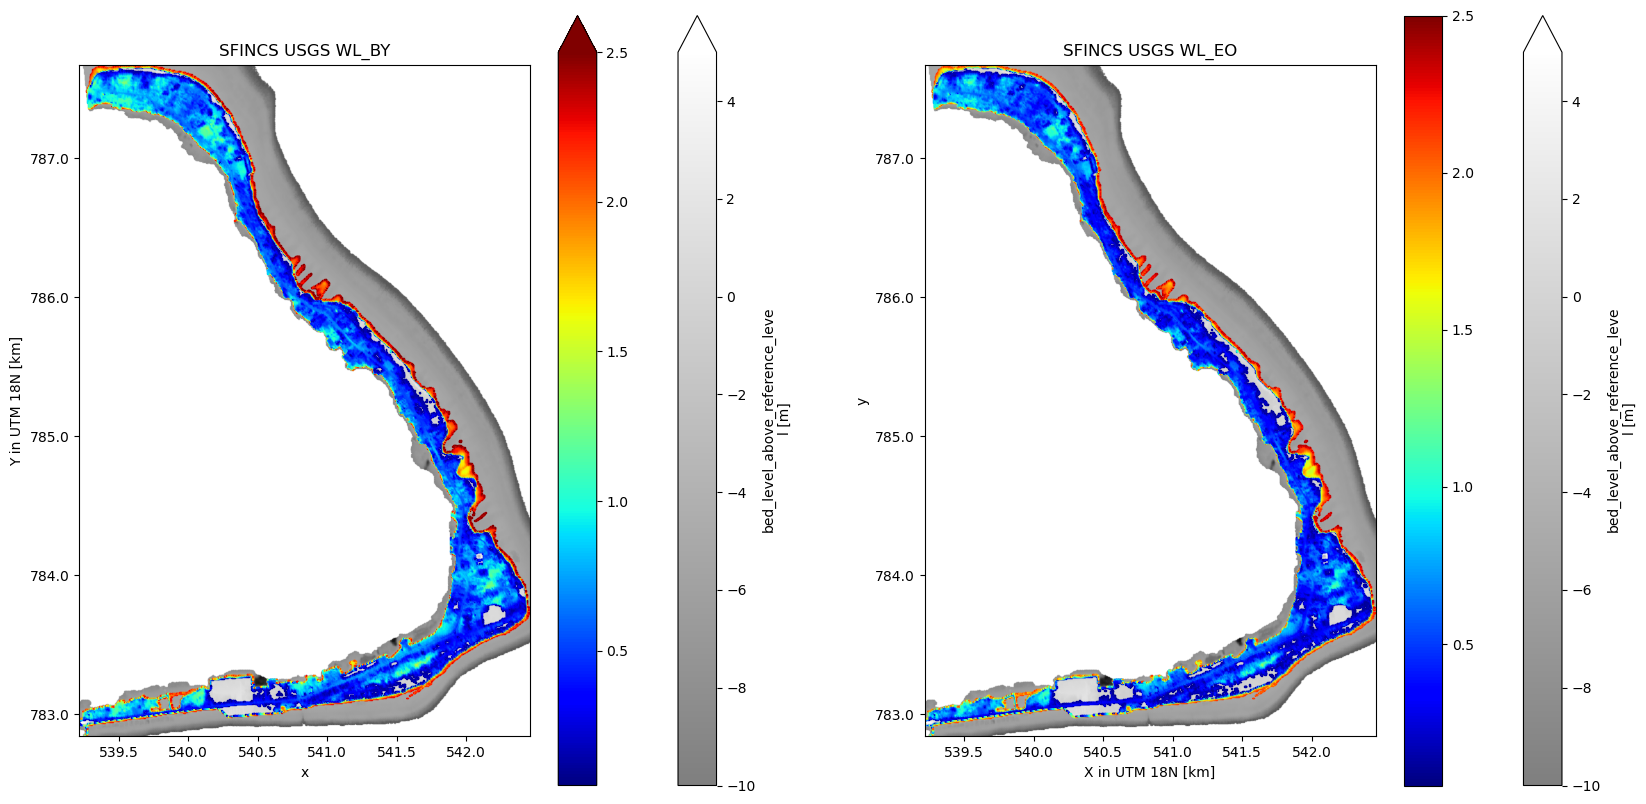

In [40]:
ncname = {}
nc_folder = {}

WL_by = 1.29 #[1.13,1.23,1.29]
WL_eo = 1.16 #[0.86,1.03,1.16]
SLR = 1.0

id = 0
ncname[id] = 'SFINCS USGS WL_BY'
nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_1_usgs\slr_{}_wl_{}'.format(SLR, WL_by)

nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')
xu_nc = xu.open_dataset(nc_file, decode_times=False)
bed_level = xu_nc['zb']
filtered_water_level = xu_nc['zsm']

# water_level_max = xu_nc['zsm'].max(axis = 0)
# water_level_max_ref =  water_level_max - bed_level
# difference_initially = filtered_water_level[0] - bed_level
# dry_idx_SLR = difference_initially < 0.001 - SLR
# dry_idx = difference_initially < 0.001 

# Plot max waterlevel
# fig, ax = plt.subplots(1,1, figsize = (8,8))
# bed_level.ugrid.plot(ax=ax, alpha  = 0.5, cmap='gray')
# water_level_max_ref = water_level_max_ref[dry_idx] # Initially dry
# water_level_max_ref = water_level_max_ref[water_level_max_ref > 0.05] # Larger tahn 0.05 m
# water_level_max_ref.ugrid.plot(ax = ax, vmin = 0.05, vmax=  2.5)
# ax.set_title("Maximum water depth at initially dry areas larger than 5 cm")

id += 1
ncname[id] = 'SFINCS USGS WL_EO'
nc_folder[id] = r'p:\11207365-eoatsee\Majuro\models\SFINCS\03_modelruns\v2_full\domain_0000_1_usgs\slr_{}_wl_{}'.format(SLR, WL_eo)

fig, axes = plt.subplots(1, len(nc_folder), figsize=(20,10), sharex=False, gridspec_kw={'hspace': 0.35})
axes_flat = axes.flat

for id in range(len(nc_folder)):

# for id, value in enumerate(nc_folder):
    nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')

    xu_nc = xu.open_dataset(nc_file, decode_times=False)

    # zb = xu_nc["zb"]
    # zsmax = xu_nc["zsmax"].max(dim="timemax")    
    bed_level = xu_nc['zb']
    filtered_water_level = xu_nc['zsm']
    water_level_max = xu_nc['zsm'].max(axis = 0)
    water_level_max_ref =  water_level_max - bed_level
    difference_initially = filtered_water_level[0] - bed_level #should remove
    dry_idx_SLR = difference_initially < 0.001 - SLR #should remove
    dry_idx = difference_initially < 0.001 #should remove
    
    xu_nc.close()
    
    # Actual plot        
    hmax_simple = zsmax - zb
    hmax_simple[hmax_simple <= 0.001] = None
    
    ax = axes_flat[id]
    bed_level.ugrid.plot(ax=ax, alpha  = 0.5, cmap='gray',vmin = -10, vmax=  5)
    water_level_max_ref = water_level_max_ref[dry_idx] # Initially dry
    water_level_max_ref = water_level_max_ref[water_level_max_ref > 0.1] # Larger tahn 0.05 m
    water_level_max_ref.ugrid.plot(ax = ax, vmin = 0.05, vmax=  2.5, cmap = 'jet')
    # hmax_simple.ugrid.plot(ax=ax,cmap='GnBu', vmin = 0, vmax = 3, add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55, 'alpha':0.5})
    
    ax.set_title(ncname[id])
    if id >= 1:
        ax.set_xlabel('X in UTM 18N [km]')
    if id % 2 == 0: #even number       
        ax.set_ylabel('Y in UTM 18N [km]')
    # else:
        # ax.set_xlabel('X in UTM 18N [km]')

    ax.set_aspect('equal', adjustable='box')

    ax.set_xticklabels([x/1e3 for x in ax.get_xticks()])  # divide every tick value by 1000
    ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
    
    # ax.set_alpha(0.5)


fig.tight_layout()

fig.savefig('figure_detail_flooding_comparison_WL50yr_SLR1',dpi=500)
  
    


C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2185369887.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([x/1e3 for x in ax2.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2185369887.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([y/1e3 for y in ax2.get_yticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2185369887.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([x/1e3 for x in ax3.get_xticks()])  # divide every tick value by 1000
C:\Users\gawehn\AppData\Local\Temp\ipykernel_1108\2185369887.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([y/1e3 for y in ax3.get_yticks()])  # divide every tick value by 1000


[Text(0, 782000.0, '782.0'),
 Text(0, 783000.0, '783.0'),
 Text(0, 784000.0, '784.0'),
 Text(0, 785000.0, '785.0'),
 Text(0, 786000.0, '786.0'),
 Text(0, 787000.0, '787.0'),
 Text(0, 788000.0, '788.0'),
 Text(0, 789000.0, '789.0')]

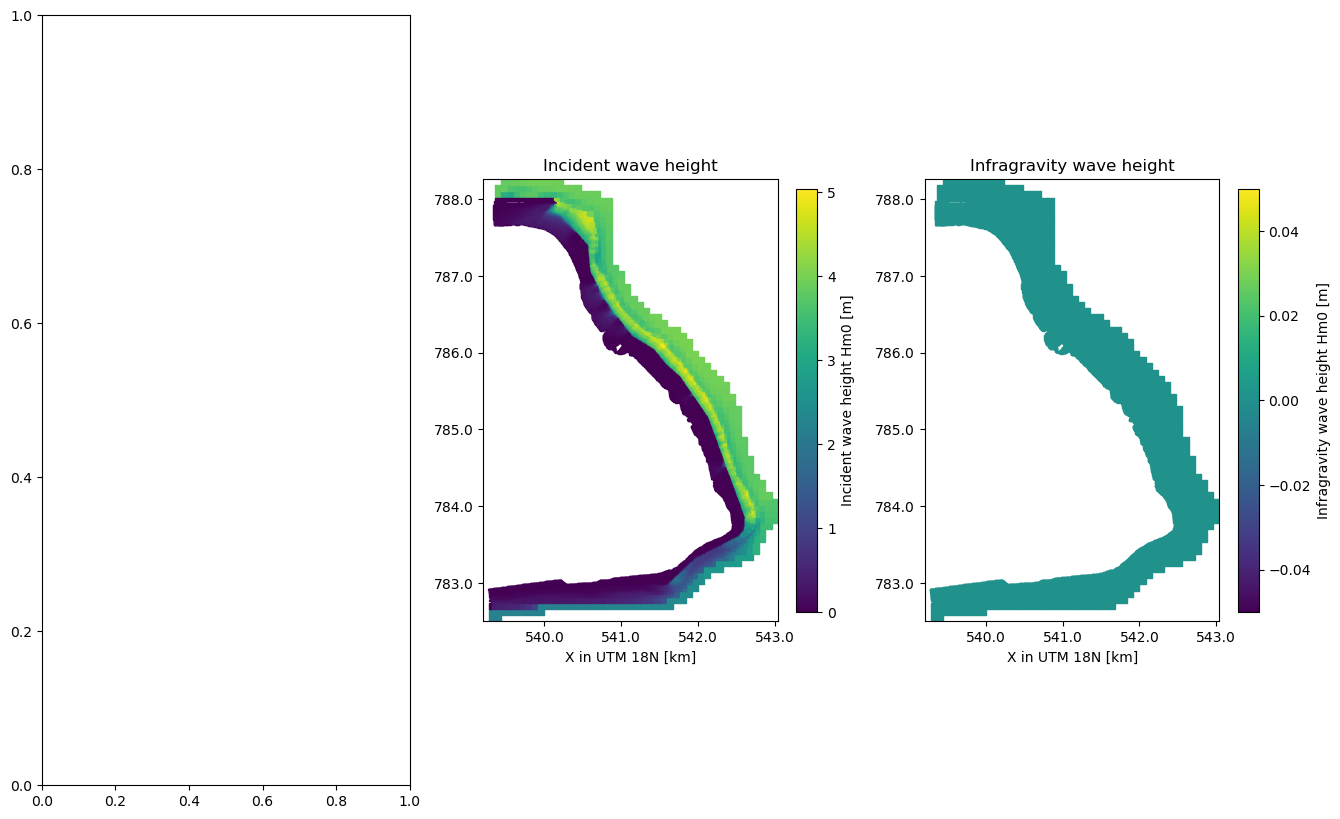

In [21]:
#val0 = -1*modig['snapwavedepth']

val2 = modig['hm0']#[(modig['zb']>-200)]# & (modig['zb']<0.7)]
# val2 = val2 / np.sqrt(2.0)

val3 = modig['hm0ig']
# val3 = val3 / np.sqrt(2.0)

fig, ([ax0, ax2, ax3]) = plt.subplots(figsize=(22.6/1.4,10), ncols=3, nrows=1)#, sharex=True, sharey=True)

#plot1 = val0.ugrid.plot(ax=ax0, vmin=-30.0, vmax=5.0, add_labels=False, cbar_kwargs={'label':'Elevation [m+NAVD88]','shrink':0.55})

val2.ugrid.plot(ax=ax2, add_labels=False, cbar_kwargs={'label':'Incident wave height Hm0 [m]','shrink':0.55})

val3.ugrid.plot(ax=ax3, add_labels=False, cbar_kwargs={'label':'Infragravity wave height Hm0 [m]','shrink':0.55}) # 0.5

# ax0.set_title('Bed level Snapwave')
# ax0.set_aspect('equal', adjustable='box')
# ax0.set_xlabel('X in UTM 18N [km]')
# ax0.set_ylabel('Y in UTM 18N [km]')

ax2.set_title('Incident wave height')
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('X in UTM 18N [km]')

ax3.set_title('Infragravity wave height')
ax3.set_aspect('equal', adjustable='box')
ax3.set_xlabel('X in UTM 18N [km]')
ax3.set_ylabel('')

# ax0.set_xticklabels([x/1e3 for x in ax0.get_xticks()])  # divide every tick value by 1000
# ax0.set_yticklabels([y/1e3 for y in ax0.get_yticks()])  # divide every tick value by 1000

ax2.set_xticklabels([x/1e3 for x in ax2.get_xticks()])  # divide every tick value by 1000
ax2.set_yticklabels([y/1e3 for y in ax2.get_yticks()])  # divide every tick value by 1000

ax3.set_xticklabels([x/1e3 for x in ax3.get_xticks()])  # divide every tick value by 1000
ax3.set_yticklabels([y/1e3 for y in ax3.get_yticks()])  # divide every tick value by 1000



# ax0.text(540*1e3, 3825*1e3, r"(a)",ha='right')
# ax2.text(540*1e3, 3825*1e3, r"(b)",ha='right')
# ax3.text(540*1e3, 3825*1e3, r"(c)",ha='right')

#
# fig.savefig('figure_overview_zb_hinc_hig',dpi=500)

In [33]:
val0 = modig['zb']

val1 = modig['zsm']
val1b = modig['zsm0']
val1 = val1 - val1b
idwet = val1b - val0
val1[val1 <= 0.001] = None
val1[idwet <= 0.001] = None


# val2 = modig['zsmax']
# val2 = val2 - val0
# val2[val2 <= 0.001] = None

fig, ([ ax0, ax1]) = plt.subplots(figsize=(22.6/1.4,6), ncols=2, nrows=1, sharex=True, sharey=True)

# # show(rsim, ax=ax0, zorder=0)
# # show(rsim, ax=ax1, zorder=0)
# # show(rsim, ax=ax2, zorder=0)

val0.ugrid.plot(ax=ax0, vmin=-5, vmax=5.0,cmap='coolwarm', alpha=0.5, add_labels=False, cbar_kwargs={'label':'Bed level [m]','shrink':0.55,'alpha':0.5})
val1.ugrid.plot(ax=ax1, vmin=0.001, vmax=0.01,cmap='GnBu', alpha=0.5, add_labels=False, cbar_kwargs={'label':'Mean wave setup [m]','shrink':0.55,'alpha':0.5})

# # val2.ugrid.plot(ax=ax0, vmin=0, vmax=3.0,cmap='GnBu', alpha=0.5, add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55,'alpha':0.5})

# ax0.set_title('Maximum water depth')
# ax0.set_xlabel('X in UTM 18N [km]')
ax0.set_ylabel('Y in UTM 18N [km]')
ax1.set_title('Mean wave setup')
ax1.set_xlabel('X in UTM 18N [km]')
ax0.set_title('Bed level')
ax0.set_xlabel('X in UTM 18N [km]')

# # ax0.plot((310409.7, 315666.0), (6695523.1, 6697364.4),'lightgrey')
# # ax1.plot((310409.7, 315666.0), (6695523.1, 6697364.4),'lightgrey')
# # ax2.plot((310409.7, 315666.0), (6695523.1, 6697364.4),'lightgrey')

# #%% High runup - from: Sfincs_output_locations_utm36S.txt
# #% High beach runup monitoring locations
# # runupx = [311111.4 , 310892.7, 310728.4, 310386.7]
# # runupy = [6694662.9, 6695082.2, 6695696.2, 6696688.8 ]
# # runupname = {'upper beach location 1','upper beach location 2','upper beach location 3','upper beach location 4'};
# # ax0.scatter(runupx, runupy, color='r',marker='^')

# ##%% Promenade flooding - from: Sfincs_output_locations_utm36S.txt
# #% Promenade flooding monitoring locations
# # promenadex = [311084.6, 310859.4, 310693.4, 310353.1]
# # promenadey = [6694645.1, 6695069.7, 6695689.6, 6696681.6 ]
# # promenadename = {'promenade edge 1','promenade edge 2','promenade edge 3','promenade edge 4'};
# # ax0.scatter(promenadex, promenadey, color='orange',marker='s')

# # ax0.set_xlim(310000, 312000)
# #  
# # ax0.set_ylim(6694700-500, 6696500+500)

# ax0.set_aspect('equal', adjustable='box')

# ax0.set_xticklabels([x/1e3 for x in ax0.get_xticks()])  # divide every tick value by 1000
# ax0.set_yticklabels([y/1e3 for y in ax0.get_yticks()])  # divide every tick value by 1000
# ax1.set_xticklabels([x/1e3 for x in ax1.get_xticks()])  # divide every tick value by 1000
# ax1.set_yticklabels([y/1e3 for y in ax1.get_yticks()])  # divide every tick value by 1000
# ax2.set_xticklabels([x/1e3 for x in ax2.get_xticks()])  # divide every tick value by 1000
# ax2.set_yticklabels([y/1e3 for y in ax2.get_yticks()])  # divide every tick value by 1000

# fig.savefig('figure_detail_flooding',dpi=500)

IndexError: 2-dimensional boolean indexing is not supported. 

## Compare runs

C:\Users\gawehn\miniconda3\envs\eoatsee2\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\gawehn\miniconda3\envs\eoatsee2\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\gawehn\miniconda3\envs\eoatsee2\lib\site-packages\xarray\backends\plugins.py:148: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\gawehn\miniconda3\envs\eoatsee2\lib\site-packages\xarray\backends\plugins.py:148: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\gawehn\miniconda3\envs\eoatsee2\lib\site-packages\xarray\backends\plugins.py:148: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while 

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

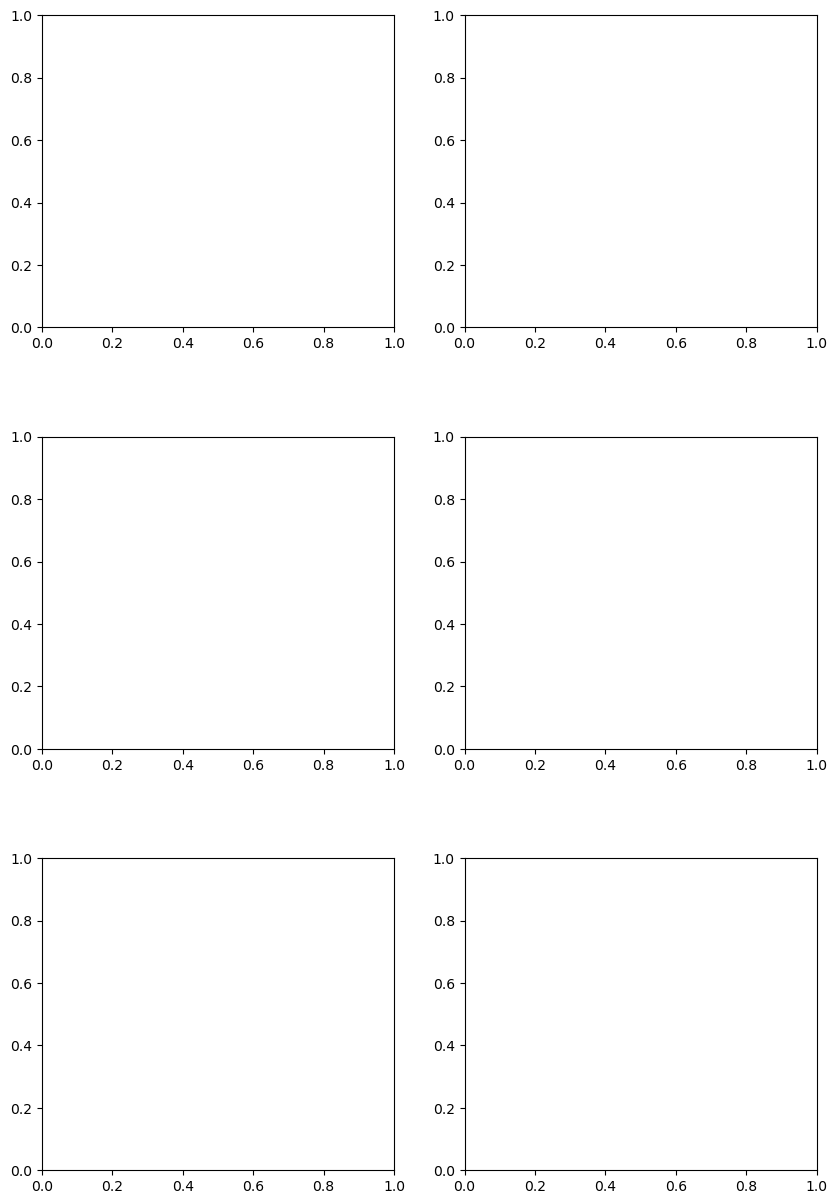

In [34]:
ncname = {}
nc_folder = {}

id = 0
ncname[id] = 'SF+SW inc+IG wavemaker'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5'
id += 1
ncname[id] = 'SF+SW inc+IG setup'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5\no_wavemaker'
id += 1
ncname[id] = 'SF+SW inc setup'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5\no_wavemaker_no_IG'
id += 1
ncname[id] = 'SF Stockdon setup'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5\setup_Stockdon'
id += 1
ncname[id] = 'SF 20%Hs setup'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5\setup_20pHs'
id += 1
ncname[id] = 'SF no setup'
nc_folder[id] = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Durban\CHT\version_01_test5\no_setup'

num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,15), sharex=False, gridspec_kw={'hspace': 0.35})

id = 0
for i in range(num_rows):
    for j in range(num_cols):

# for id, value in enumerate(nc_folder):
        nc_file = os.path.join(nc_folder[id],'sfincs_map.nc')

        xu_nc = xu.open_dataset(nc_file, decode_times=False)

        zb = xu_nc["zb"]
        zsmax = xu_nc["zsmax"].max(dim="timemax")    

        xu_nc.close()
        
        # Actual plot        
        hmax_simple = zsmax - zb
        hmax_simple[hmax_simple <= 0.001] = None

        ax = axes[i, j]

        show(rsim, ax=ax, zorder=0)

        hmax_simple.ugrid.plot(ax=ax, vmin=0, vmax=3.0,cmap='GnBu', add_labels=False, cbar_kwargs={'label':'Maximum water depth [m]','shrink':0.55, 'alpha':0.5})

        ax.set_title(ncname[id])
        if id >= 4:
            ax.set_xlabel('X in UTM 18N [km]')
        if id % 2 == 0: #even number       
            ax.set_ylabel('Y in UTM 18N [km]')
        # else:
            # ax.set_xlabel('X in UTM 18N [km]')
        
        ax.set_xlim(310300, 311300)
        ax.set_ylim(6694700, 6696500)

        ax.set_aspect('equal', adjustable='box')

        ax.set_xticklabels([x/1e3 for x in ax0.get_xticks()])  # divide every tick value by 1000
        ax.set_yticklabels([y/1e3 for y in ax0.get_yticks()])  # divide every tick value by 1000
        
        # ax.set_alpha(0.5)
        
        id = id+1

fig.tight_layout()

fig.savefig('figure_detail_flooding_comparison',dpi=500)
  
    
